# Data Analysis of MEDSBE with TF-IDF

In [36]:
import mwdsbe
import mwdsbe.datasets.licenses as licenses
import schuylkill as skool
import pandas as pd
import time
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
registry = mwdsbe.load_registry() # geopandas df
license = licenses.CommercialActivityLicenses().get()

In [20]:
# clean data
ignore_words = ['inc', 'group', 'llc', 'corp', 'pc', 'incorporated', 'ltd', 'co', 'associates', 'services', 'company', 'enterprises', 'enterprise', 'service', 'corporation']
cleaned_registry = skool.clean_strings(registry, ['company_name', 'dba_name'], True, ignore_words)
cleaned_license = skool.clean_strings(license, ['company_name'], True, ignore_words)

cleaned_registry = cleaned_registry.dropna(subset=['company_name'])
cleaned_license = cleaned_license.dropna(subset=['company_name'])

In [21]:
print('Total number of cleaned registry:', len(cleaned_registry))

Total number of cleaned registry: 3119


In [22]:
print('Total number of cleaned license:', len(cleaned_license))

Total number of cleaned license: 203541


## TF-IDF 85

In [110]:
t1 = time.time()
merged = (
    skool.tf_idf_merge(cleaned_registry, cleaned_license, on="company_name", score_cutoff=85)
    .pipe(skool.tf_idf_merge, cleaned_registry, cleaned_license, left_on="dba_name", right_on="company_name", score_cutoff=85)
)
t = time.time() - t1

In [111]:
print('Execution time:', t/60, 'min')

Execution time: 3.0333751757939655 min


In [112]:
matched = merged.dropna(subset=['company_name_y'])

In [113]:
# matched = pd.read_excel(r'C:\Users\dabinlee\Desktop\mwdsbe\data\tf-idf\tf-idf-85.xlsx')

In [114]:
print('Matched:', len(matched), 'out of', len(cleaned_registry))

Matched: 1499 out of 3119


##### Getting only active companies

In [79]:
active_matched = matched[matched.license_status == 'Active']

NameError: name 'matched' is not defined

In [25]:
print('Active Companies:', len(active))

Active Companies: 1487


## Does the license issue year affect the threshold?

### 1) All year trends

In [98]:
# getting only active companies in whole license data
active_license = cleaned_license[cleaned_license.license_status == 'Active']

In [99]:
active_license['issue_year'] = active_license['issue_date'].dt.year

C:\Users\dabinlee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
years = active_license.groupby('issue_year').size().to_frame('N').reset_index()

In [102]:
years

issue_year      N
0         1990      5
1         1991      1
2         1993    609
3         1994   1653
4         1995   3178
5         1996   3588
6         1997   2899
7         1998   3155
8         1999   3370
9         2000   3752
10        2001   3073
11        2002   3634
12        2003   3956
13        2004   5622
14        2005  64349
15        2006   9187
16        2007   8840
17        2008   6776
18        2009   5324
19        2010   5632
20        2011   5934
21        2012   5314
22        2013   6578
23        2014   7864
24        2015   7407
25        2016   7050
26        2017   7912
27        2018   8402
28        2019   7181

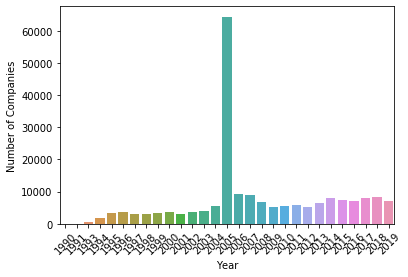

In [104]:
ax = sns.barplot(x="issue_year", y="N", data=years)
ax.set(xlabel='Year', ylabel='Number of Companies')
ax.set_xticklabels(labels=years.issue_year, rotation=45)
plt.show()

### 2) Only considering the most recent year = 2019

In [105]:
license_2019 = active_license[active_license.issue_year == 2019]

In [115]:
# tf-idf-merge with registry and license_2019 to see if this makes a difference
t1 = time.time()
merged_2019 = (
    skool.tf_idf_merge(cleaned_registry, license_2019, on="company_name", score_cutoff=85)
    .pipe(skool.tf_idf_merge, cleaned_registry, license_2019, left_on="dba_name", right_on="company_name", score_cutoff=85)
)
t = time.time() - t1

In [116]:
print('Execution time:', t, 'sec')

Execution time: 0.8770878314971924 sec


In [117]:
matched_2019 = merged_2019.dropna(subset=['company_name_y'])

In [150]:
print('Matched:', len(matched_2019), 'out of', len(cleaned_registry))

Matched: 61 out of 3119


In [138]:
## To see the difference between filtering 2019 after tf-idf and before tf-idf
matched['issue_year'] = matched['issue_date'].dt.year

C:\Users\dabinlee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [143]:
matched_test = matched[matched.issue_year == 2019]

In [151]:
len(matched_test)

46

### a) Clearifying before and after merge difference
Since we are finding best match for tf-idf, there are some best matches not in 2019, so if we do tf-idf-merge and filter by 2019 license year, we get less than filtering before the merge.

In [152]:
before = matched_2019
after = matched_test

In [162]:
diff = before.index.difference(after.index).tolist()

In [173]:
result_before = before.loc[diff]

In [224]:
result_before[['company_name_x', 'match_probability', 'company_name_y', 'issue_year', 'license_num']]

company_name_x match_probability  \
registry_id                                                    
35                            a m painting          0.852668   
51                        abc construction                 1   
56                                abstract                 1   
104            advantage building facility                 1   
668                          collaborative          0.859109   
914            dw environmental consulting          0.856184   
1155         garden state highway products                 1   
1265                          h s cleaning          0.869138   
1951                      myers constructs          0.901206   
2005                      nico landscaping                 1   
2299             r r contracting utilities                 1   
2343                      reliable transit             0.908   
2443                    salt design studio                 1   
2530                      sioutis coatings                 1   
3076                      wong fleming p c          0.877663   

                            company_name_y  issue_year  license_num  
registry_id                                                          
35                              m painting      2019.0     808498.0  
51                        abc construction      2019.0     824402.0  
56                                abstract      2019.0     814936.0  
104            advantage building facility      2019.0     820119.0  
668                       oz collaborative      2019.0     825349.0  
914               environmental consulting      2019.0     804696.0  
1155         garden state highway products      2019.0     820258.0  
1265                          l s cleaning      2019.0     827771.0  
1951                    myers construction      2019.0     818308.0  
2005                      nico landscaping      2019.0     810366.0  
2299             r r contracting utilities      2019.0     804256.0  
2343                   gs reliable transit      2019.0     821288.0  
2443                    salt design studio      2019.0     825844.0  
2530                      sioutis coatings      2019.0     804514.0  
3076                          wong fleming      2019.0     820989.0

In [175]:
result_after = matched.loc[diff]

In [223]:
result_after[['company_name_x', 'match_probability', 'company_name_y', 'issue_year', 'license_num']]

company_name_x  match_probability  \
registry_id                                                     
35                            a m painting           0.877283   
51                        abc construction           1.000000   
56                                abstract           1.000000   
104            advantage building facility           1.000000   
668                          collaborative           1.000000   
914            dw environmental consulting           0.872052   
1155         garden state highway products           1.000000   
1265                          h s cleaning           1.000000   
1951                      myers constructs           1.000000   
2005                      nico landscaping           1.000000   
2299             r r contracting utilities           1.000000   
2343                      reliable transit           1.000000   
2443                    salt design studio           1.000000   
2530                      sioutis coatings           1.000000   
3076                      wong fleming p c           1.000000   

                            company_name_y  issue_year  license_num  
registry_id                                                          
35                            t m painting        2008     451977.0  
51                        abc construction        1994      10250.0  
56                                abstract        2010     513161.0  
104            advantage building facility        2013     591196.0  
668                          collaborative        2004     157918.0  
914               environmental consulting        1999     121391.0  
1155         garden state highway products        2002       2191.0  
1265                          h s cleaning        2004     194629.0  
1951                      myers constructs        1997     104018.0  
2005                      nico landscaping        2005      19972.0  
2299             r r contracting utilities        2010     513784.0  
2343                      reliable transit        2011     544594.0  
2443                    salt design studio        2004     171930.0  
2530                      sioutis coatings        2010     170579.0  
3076                      wong fleming p c        2005     310461.0

### b) Does one company have multiple licenses?

In [219]:
license_duplicates = cleaned_license[cleaned_license.license_num.duplicated()]

In [222]:
license_duplicates

license_num                issue_date license_status  \
76960           NaN 2005-01-28 00:00:00+00:00         Active   
118761          NaN 2007-08-28 00:00:00+00:00         Active   
123230          NaN 2008-04-07 00:00:00+00:00         Active   
123246          NaN 2008-04-08 00:00:00+00:00         Active   
126252          NaN 2008-08-22 00:00:00+00:00         Active   
130167          NaN 2009-06-02 00:00:00+00:00         Active   
136107          NaN 2010-06-04 00:00:00+00:00         Active   
136120          NaN 2010-06-04 00:00:00+00:00         Active   
142876          NaN 2011-08-09 00:00:00+00:00         Active   
148314          NaN 2012-06-25 00:00:00+00:00         Active   
159045          NaN 2014-03-17 00:00:00+00:00         Active   
173660          NaN 2016-02-24 00:00:00+00:00         Active   

                      company_name  
76960               reimar f duerr  
118761                  mc fashion  
123230      vincent and susan ross  
123246          net communications  
126252  american waste consultants  
130167                lypyak ruvim  
136107                   b k pizza  
136120       bernstein engineering  
142876                 hk wireless  
148314         communication first  
159045    ultrabeauty spa and sale  
173660        capital p management

In [220]:
len(license_duplicates)

12

##### 12 license duplicates but all nan licenses so there is no real license duplicates

In [203]:
license_groupby_company = cleaned_license.groupby('company_name').size().to_frame('N')

In [221]:
len(license_groupby_company[license_groupby_company.N > 1])

8500

##### there are companies which have more than 1 license. However, since we know that there is no same license numbers, so we know that some companies have multiple licenses.

### c) Companies having multiple license issue_year - mostly different license number
See how much companies are like this and consider to take the most recent year

In [6]:
t1 = time.time()
merged_4_matches = (
    skool.tf_idf_merge(cleaned_registry, cleaned_license, on="company_name", score_cutoff=85, max_matches=4)
    .pipe(skool.tf_idf_merge, cleaned_registry, cleaned_license, left_on="dba_name", right_on="company_name", score_cutoff=85, max_matches=4)
)
t = time.time() - t1

In [7]:
print('Execution time:', t/60, 'min')

Execution time: 3.5883587559064227 min


In [8]:
matched_4_matches = merged_4_matches.dropna(subset=['company_name_y'])

In [9]:
len(matched_4_matches)

1858

##### checking tf-idf merge is working properly

In [10]:
company_license_n = matched_4_matches.groupby('company_name_x').size().to_frame('N').reset_index()

In [11]:
company_license_n[company_license_n.N > 1]

company_name_x  N
9              a c environmental  3
10    a g consulting engineering  2
14                  a m electric  2
15                  a m painting  4
16         a m truck auto repair  2
...                          ... ..
1469  west chester environmental  2
1478                   winzinger  4
1480            wong fleming p c  2
1490                       yikes  2
1496               zizza highway  2

[262 rows x 2 columns]

In [12]:
company_license_n[company_license_n.company_name_x == 'abc construction']

company_name_x  N
21  abc construction  4

### d) Trends of Companies with multiple licenses

In [70]:
t1 = time.time()
merged_4_matches = (
    skool.tf_idf_merge(cleaned_registry, cleaned_license, on="company_name", score_cutoff=85, max_matches=4)
    .pipe(skool.tf_idf_merge, cleaned_registry, cleaned_license, left_on="dba_name", right_on="company_name", score_cutoff=85, max_matches=4)
)
t = time.time() - t1

In [114]:
duplicates = merged_4_matches[merged_4_matches.duplicated(subset=['company_name_x'], keep=False)]

In [118]:
len(duplicates)

621

In [119]:
# getting only active licenses
duplicates_active = duplicates[duplicates.license_status == 'Active']

In [122]:
len(duplicates_active)

608

In [165]:
license_n = duplicates_active.groupby('company_name_x').size().to_frame('N').reset_index()

In [166]:
len(license_n)

262

In [167]:
sns.set(color_codes=True)

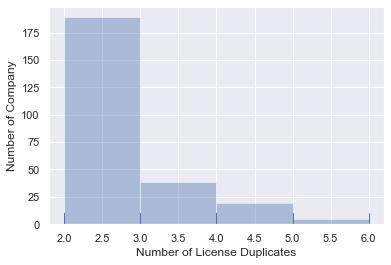

In [168]:
ax = sns.distplot(license_duplicates.N, kde=False, rug=True, bins = 4)
ax.set(xlabel='Number of License Duplicates', ylabel='Number of Company')

plt.show()

#### Question: how is it possible to have more than 4 license duplicates with max-matches=4?

### e) Trends of Issue Year in license duplicates - Histogram

#### Create Year Column by extracing it from issue_date

In [123]:
duplicates_active['issue_year'] = duplicates_active['issue_date'].dt.year

C:\Users\dabinlee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### All years

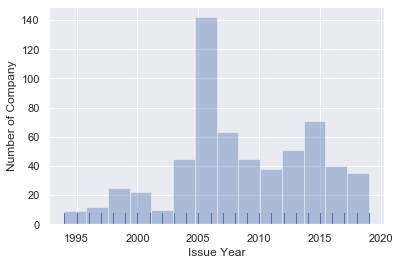

In [157]:
ax = sns.distplot(duplicates_active.issue_year, kde=False, rug=True)
ax.set(xlabel='Issue Year', ylabel='Number of Company')

plt.show()

#### Difference between min issue year and max issue year trends

In [141]:
min_year = duplicates_active.groupby('company_name_x')['issue_year'].min().to_frame('min_issue_year').reset_index()

In [145]:
max_years = duplicates_active.groupby('company_name_x')['issue_year'].max().to_frame('max_issue_year').reset_index()

In [147]:
years = min_year.merge(max_years, on='company_name_x')

In [152]:
years['diff_issue_year'] = years.max_issue_year - years.min_issue_year

In [161]:
years.head()

company_name_x  min_issue_year  max_issue_year  diff_issue_year
0           a c environmental            1996            2007               11
1  a g consulting engineering            2004            2008                4
2                a m electric            1995            2005               10
3                a m painting            1998            2019               21
4       a m truck auto repair            2000            2008                8

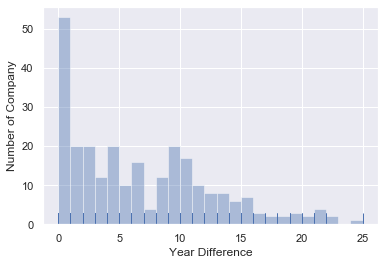

In [159]:
ax = sns.distplot(years.diff_issue_year, kde=False, rug=True, bins=25)
ax.set(xlabel='Year Difference', ylabel='Number of Company')

plt.show()